# 3_Telecom_Operator_Plan_Revenue_Analysis

<a id='back'><a/> 
# Table of Contents

- [1. Megaline Prepaid Plan Revenue Analysis Overview](#1)
- [2. General Information Review](#2)
    - [2.1 Plans File](#2.1)
    - [2.2 Calls File](#2.2)
    - [2.3 Internet File](#2.3)
    - [2.4 Messages File](#2.4)
    - [2.5 Users File](#2.5)
    - [2.6 Conclusion](#2.6)
- [3. Data Preprocessing](#3)
    - [3.1 Changing Data Types](#3.1)
    - [3.2 Additional Calculations to Perform](#3.1)
- [4. Exploratory Data Analysis](#4)
    - [4.2 Data Analysis](#4.2)
- [5. Hypothesis Testing](#5)
    - [5.1 Test 1: Average profit from users of Ultimate and Surf calling plans differs](#5.1)
    - [5.2 Test 2: Average profit from users in NY / NJ area is different from that of the users from other regions](#5.2)
- [6. General Conclusion](#6)

<a id='1'><a/> 
# 1 Megaline Prepaid Plan Revenue Analysis Overview
[Return to Table of Contents](#back)

Megaline is a telecom operator that offers two prepaid plans: Surf and Ultimate. The commercial
department wants to know which of the plans generates higher revenue in order to adjust the advertising budget.

Using 2018 calendar year data from a small client selection (i.e. 500 Megaline clients), we will analyze clients' behavior to determine which prepaid plan generates more revenue. To complete this analysis, we will perform the following:
<ul>
 <li>General Information Review</li>
 <li>Data Preprocessing</li>
 <li>Exploratory Data Analysis</li>
 <li>Hypothesis Testing</li>
 </ul>
 
At the end of our study, we will provide a recommendation to Management regarding how to allocate advertisement budgets.

<a id='2'><a/> 
# 2 General Information Review
[Return to Table of Contents](#back)

In [1]:
# import libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statistics
import math
from scipy import stats as st

In [2]:
# read all input data

try: # local path
    df_plan= pd.read_csv('megaline_plans.csv')
    df_calls= pd.read_csv('megaline_calls.csv')
    df_data= pd.read_csv('megaline_internet.csv')
    df_texts= pd.read_csv('megaline_messages.csv')
    df_users= pd.read_csv('megaline_users.csv')
except: # server path
    df_plan= pd.read_csv('/datasets/megaline_plans.csv')
    df_calls= pd.read_csv('/datasets/megaline_calls.csv')
    df_data= pd.read_csv('/datasets/megaline_internet.csv')
    df_texts= pd.read_csv('/datasets/megaline_messages.csv')
    df_users= pd.read_csv('/datasets/megaline_users.csv')

<a id='2.1'><a/> 
## 2.1 Plans File
[Return to Table of Contents](#back)

In [3]:
# general phone plan information

df_plan.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [4]:
df_plan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


There is no preprocessing that needs to be done to this file. "Plan_name" should actually be a category type, but leaving as is will not impact our analysis. It is important to note that this file uses two types of metrics for data, mb and gb. We will need to convert all to mb later.
<br>
<br>
Important note regarding data for both plans:
<br>
Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls, each individual call is rounded up. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up.

<a id='2.1'><a/> 
## 2.2 Calls File
[Return to Table of Contents](#back)

In [5]:
df_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [6]:
df_calls['user_id'].nunique()

481

In [7]:
df_calls.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 19.4 MB


In [8]:
df_calls.duration.describe()

count    137735.000000
mean          6.745927
std           5.839241
min           0.000000
25%           1.290000
50%           5.980000
75%          10.690000
max          37.600000
Name: duration, dtype: float64

In [9]:
df_calls.isnull().sum()

id           0
user_id      0
call_date    0
duration     0
dtype: int64

In [10]:
df_calls.duplicated().sum()

0

Of the 500 clients, 481 plan users made calls at some point during the year. Preprocessing is minimal. There are no missing values or duplicates. The file uses a fair amount of memory (19.4 MB), largely due to the number of lines, approx, 140,000. Changing the two of the series types should lower that: 'user_id' does not need to be 64 bits and 'duration' can be changed to an int. In addition, 'call_date' needs to be changed to datetime.

<a id='2.3'><a/> 
## 2.3 Internet File
[Return to Table of Contents](#back)

In [11]:
df_data.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [12]:
df_data['user_id'].nunique()

489

In [13]:
df_data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 14.8 MB


In [14]:
df_data.describe()

,user_id,mb_used
count,104825.000000,104825.000000
mean,1242.496361,366.713701
std,142.053913,277.170542
min,1000.000000,0.000000
25%,1122.000000,136.080000
50%,1236.000000,343.980000
75%,1367.000000,554.610000
max,1499.000000,1693.470000


In [15]:
df_data.isnull().sum()

id              0
user_id         0
session_date    0
mb_used         0
dtype: int64

In [16]:
df_data.duplicated().sum()

0

Of the 500 clients, 489 plan users used data at some point during the year. Preprocessing is minimal. There are no missing values or duplicates. 'Session_date' type needs to be changed to datetime. We can also correct the data types for two other series: 'user_id' does not need to be 64 bits and 'mb_used' can be changed to an int; these changes can be done to save memory, but are not necessary steps.

<a id='2.4'><a/> 
## 2.4 Messages File
[Return to Table of Contents](#back)

In [17]:
df_texts.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [18]:
df_texts['user_id'].nunique()

402

In [19]:
df_texts.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 10.1 MB


In [20]:
df_texts.isnull().sum()

id              0
user_id         0
message_date    0
dtype: int64

In [21]:
df_texts.duplicated().sum()

0

Of the 500 clients, 402 plan users used data at some point during the year, indicating that texting is the feature least used amongst clients. Preprocessing is minimal. There are no missing values or duplicates. 'Message_date' type needs to be changed to datetime. We can also correct the data types for 'user_id', which does not need to be 64 bits, if we want to save memory, though this is not a necessary step.

<a id='2.5'><a/> 
## 2.5 Users File
[Return to Table of Contents](#back)

In [22]:
df_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


In [23]:
df_users.groupby('plan')['plan'].count()

plan
surf        339
ultimate    161
Name: plan, dtype: int64

In [24]:
df_users.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 194.9 KB


In [25]:
df_users.isnull().sum()

user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64

In [26]:
df_users.duplicated().sum()

0

Of the 500 clients, 339 are signed up for the cheaper "Ultimate" plan, while 161 are signed up for the "Surf" plan, which is important to note as these different sample sizes might impact any statistical analysis. Preprocessing in this file is also minimal. We only need to make three type changes. 'Reg_date' and 'churn_date' need to be converted to dt type. 'Plan' should also be converted to datatype category.

<a id='2'><a/> 
## 2.6 Conclusion
[Return to Table of Contents](#back)

For this analysis, we were provided with five different files, one which contains general plan information and four that contain information on the plan features of which the 500 Megaline clients use. All of the data is from 2018. The "surf" plan is almost twice as popular as the more expensive "ultimate" plan. 

Across the files there were no missing values that need to be corrected / filled and there were no duplicates that need to be dropped. Preprocessing that needs to be done is conversion of select columns to the correct type and also conversion of the data metrics used in the "Plan" file so that data is evaluated in GB only.

<a id='3'><a/> 
# 3 Data Preprocessing
[Return to Table of Contents](#back)

<a id='3.1'><a/> 
## 3.1 Changing Data Types
[Return to Table of Contents](#back)

In [27]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])
df_data['session_date'] = pd.to_datetime(df_data['session_date'])
df_texts['message_date'] = pd.to_datetime(df_texts['message_date'])
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'])

df_users['plan'] = df_users['plan'].astype('category')

In [28]:
df_calls['duration'] = np.ceil(df_calls['duration'])

The necessary series were converted to their correct types and call durations were rounded up as per the terms of the plans.

<a id='3.2'><a/> 
## 3.2 Additional Calculations to Perform
[Return to Table of Contents](#back)

<a id='3.2.1'><a/> 
### 3.2.1 Monthly Plan Usage
[Return to Table of Contents](#back)

As a first step to determing which plan generates more revenue, for each user, we must calcualte the number of calls made and minutes used per month, the number of text messages sent per month, the volume of data used per month

In [29]:
df_calls['month_year'] = df_calls.call_date.dt.to_period('M')
df_texts['month_year'] = df_texts.message_date.dt.to_period('M')
df_data['month_year'] = df_data.session_date.dt.to_period('M')

In [30]:
df_calls.head()

,id,user_id,call_date,duration,month_year
0,1000_93,1000,2018-12-27,9.0,2018-12
1,1000_145,1000,2018-12-27,14.0,2018-12
2,1000_247,1000,2018-12-27,15.0,2018-12
3,1000_309,1000,2018-12-28,6.0,2018-12
4,1000_380,1000,2018-12-30,5.0,2018-12


In [31]:
calls_month = df_calls.groupby(['user_id','month_year']).duration.sum()
texts_month = df_texts.groupby(['user_id','month_year']).message_date.count()
int_month = (df_data.groupby(['user_id','month_year']).mb_used.sum()/1024).apply(np.ceil)

In [32]:
df_monthly=pd.concat([calls_month, texts_month, int_month],1).reset_index().fillna(0).merge(df_users)

In [33]:
df_monthly.rename(columns={'message_date':'text_used', 'duration':'min_used', 'mb_used':'gb_used'}, inplace=True)

In [34]:
df_monthly.head()

,user_id,month_year,min_used,text_used,gb_used,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,2018-12,124.0,11.0,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1001,2018-08,182.0,30.0,7.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,1001,2018-09,315.0,44.0,14.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
3,1001,2018-10,393.0,53.0,22.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
4,1001,2018-11,426.0,36.0,19.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT


Using information from four of the five files (the plan file was not needed at this step), we were able to calcuate per user_id and month_year, the number of minutes used, the number of texts sent, and the amount of data used.

<a id='3.2.1'><a/> 
### 3.2.1 Monthly Revenue Based on Plan Usage
[Return to Table of Contents](#back)

In [35]:
df_plan

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [36]:
# Megaline package cost variables defined

surf_monthly_charge = df_plan['usd_monthly_pay'][0]
surf_min_included = df_plan['minutes_included'][0]
surf_text_included = df_plan['messages_included'][0]
surf_gb_included = df_plan['mb_per_month_included'][0] / 1024
surf_min_add_charge = df_plan['usd_per_minute'][0]
surf_text_add_charge = df_plan['usd_per_message'][0]
surf_gb_add_charge = df_plan['usd_per_gb'][0]

ultimate_monthly_charge = df_plan['usd_monthly_pay'][1]
ultimate_min_included = df_plan['minutes_included'][1]
ultimate_text_included = df_plan['messages_included'][1]
ultimate_gb_included = df_plan['mb_per_month_included'][1] / 1024
ultimate_min_add_charge = df_plan['usd_per_minute'][1]
ultimate_text_add_charge = df_plan['usd_per_message'][1]
ultimate_gb_add_charge = df_plan['usd_per_gb'][1]

In [37]:
# adding monthly payments per plan

df_monthly['monthly_charge'] = np.where(df_monthly.plan == 'surf', surf_monthly_charge, ultimate_monthly_charge)

In [38]:
# adding min, text and gb over plan

df_monthly['min_over_plan'] = (np.where(df_monthly.plan =='surf', np.maximum(df_monthly['min_used'] - 
                                surf_min_included,0), np.maximum(df_monthly['min_used'] - 
                                ultimate_min_included,0)))
df_monthly['text_over_plan'] = (np.where(df_monthly.plan =='surf', np.maximum(df_monthly['text_used'] - 
                                surf_text_included,0), np.maximum(df_monthly['text_used'] - 
                                ultimate_text_included,0)))
df_monthly['gb_over_plan'] = (np.where(df_monthly.plan =='surf', np.maximum(df_monthly['gb_used'] - 
                                surf_gb_included,0), np.maximum(df_monthly['gb_used'] - 
                                ultimate_gb_included,0)))

In [39]:
# adding additional charges for min, text and gb and thehn totaling

df_monthly['min_add_charge'] = (np.where(df_monthly.plan =='surf', df_monthly['min_over_plan']
                                *surf_min_add_charge, df_monthly['min_over_plan']*ultimate_min_add_charge))
df_monthly['text_add_charge'] = (np.where(df_monthly.plan =='surf', df_monthly['text_over_plan']
                                *surf_text_add_charge, df_monthly['text_over_plan']*ultimate_text_add_charge))
df_monthly['gb_add_charge'] = (np.where(df_monthly.plan =='surf', df_monthly['gb_over_plan']
                                *surf_gb_add_charge, df_monthly['gb_over_plan']*ultimate_text_add_charge))

df_monthly['total_add_charges'] = df_monthly['min_add_charge'] + df_monthly['text_add_charge'] + df_monthly['gb_add_charge']

In [40]:
# additional charges for a given month plus regular monthly plan payment

df_monthly['total_payment'] = df_monthly['total_add_charges'] + df_monthly['monthly_charge']

In [41]:
df_monthly.head()

,user_id,month_year,min_used,text_used,gb_used,first_name,last_name,age,city,reg_date,...,churn_date,monthly_charge,min_over_plan,text_over_plan,gb_over_plan,min_add_charge,text_add_charge,gb_add_charge,total_add_charges,total_payment
0,1000,2018-12,124.0,11.0,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,...,NaT,70,0.0,0.0,0.0,0.0,0.00,0.0,0.00,70.00
1,1001,2018-08,182.0,30.0,7.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,...,NaT,20,0.0,0.0,0.0,0.0,0.00,0.0,0.00,20.00
2,1001,2018-09,315.0,44.0,14.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,...,NaT,20,0.0,0.0,0.0,0.0,0.00,0.0,0.00,20.00
3,1001,2018-10,393.0,53.0,22.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,...,NaT,20,0.0,3.0,7.0,0.0,0.09,70.0,70.09,90.09
4,1001,2018-11,426.0,36.0,19.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,...,NaT,20,0.0,0.0,4.0,0.0,0.00,40.0,40.00,60.00


Using information from the plan file and utilizng the calculations we made in the last section, we were able to calculate for min, texts and data, the raw numbers of monthly overages and the additional charges that those overages incurred. From there we calculated the total amount that each user paid for the plan and the overages on a monthly basis. 

<a id='4'><a/> 
# 4 Exploratory Data Analysis
[Return to Table of Contents](#back)

Having calculated monthly plan usage, we were asked to provide some basic information on the customers' behavior. Specifically, we will analyze by plan the minutes, texts, and volume of data the users require per month. We were also asked to evaluate how customer's behavior translates into revenues.

In [42]:
df_monthly_ultimate = df_monthly[df_monthly['plan'] == 'ultimate']

In [43]:
df_monthly_surf = df_monthly[df_monthly['plan'] == 'surf']

In [44]:
df_monthly_surf.describe()

,user_id,min_used,text_used,gb_used,age,monthly_charge,min_over_plan,text_over_plan,gb_over_plan,min_add_charge,text_add_charge,gb_add_charge,total_add_charges,total_payment
count,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.0,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000,1573.000000
mean,1242.755245,428.749523,31.159568,16.670693,44.379530,20.0,61.458996,7.012715,3.865226,1.843770,0.210381,38.652257,40.706408,60.706408
std,139.227939,234.453150,33.566717,7.847522,16.646535,0.0,125.524813,19.470891,5.445627,3.765744,0.584127,54.456269,55.388042,55.388042
min,1001.000000,0.000000,0.000000,0.000000,18.000000,20.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
25%,1120.000000,272.000000,3.000000,12.000000,29.000000,20.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
50%,1245.000000,425.000000,24.000000,17.000000,45.000000,20.0,0.000000,0.000000,2.000000,0.000000,0.000000,20.000000,20.360000,40.360000
75%,1358.000000,576.000000,47.000000,21.000000,59.000000,20.0,76.000000,0.000000,6.000000,2.280000,0.000000,60.000000,60.360000,80.360000
max,1499.000000,1510.000000,266.000000,70.000000,75.000000,20.0,1010.000000,216.000000,55.000000,30.300000,6.480000,550.000000,570.370000,590.370000


An initial review of the data shows us that within the surf plan, hardly anyone goes over the number of texts in the plan, in the third quartile and some do use more minutes than in their plan. But it is in the gb where users are more likely to exceed what's provided in their plan. Translated into revenues, nearly half of customers at least double the cost of their orignal plan, largely attributable to the total additional charges attributed to gb overage charges.

In [45]:
df_monthly_ultimate.describe()

,user_id,min_used,text_used,gb_used,age,monthly_charge,min_over_plan,text_over_plan,gb_over_plan,min_add_charge,text_add_charge,gb_add_charge,total_add_charges,total_payment
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.0,720.0,720.0,720.000000,720.0,720.0,720.000000,720.000000,720.000000
mean,1253.330556,430.450000,37.551389,17.306944,47.719444,70.0,0.0,0.0,0.330556,0.0,0.0,0.003306,0.003306,70.003306
std,150.915644,240.508762,34.767179,7.670108,16.804088,0.0,0.0,0.0,1.627873,0.0,0.0,0.016279,0.016279,0.016279
min,1000.000000,0.000000,0.000000,0.000000,18.000000,70.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,70.000000
25%,1126.000000,260.000000,7.000000,13.000000,34.000000,70.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,70.000000
50%,1241.500000,424.000000,30.000000,17.000000,48.500000,70.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,70.000000
75%,1401.000000,565.250000,61.000000,21.000000,64.000000,70.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,70.000000
max,1497.000000,1369.000000,166.000000,46.000000,75.000000,70.0,0.0,0.0,16.000000,0.0,0.0,0.160000,0.160000,70.160000


Turning to the ultimate plan, no one goes over the minutes and texts provided within the plan and only.a very small percentage go over the data allowed in the plan. Translated into revenues, overage charges have a very small, nearly inconsequential, impact on the total revenues collected on a monthly basis.

It is important to note that given the differences in the sample sizes as noted earlier, we need to evaluate the statistical significance of these observations.

<a id='4.1'><a/> 
## 4.1 Customer Behavior
[Return to Table of Contents](#back)

In [46]:
# function to calculate statistics across plan categories

def statistics(x):
    avg_plan = x.mean()
    var_plan = np.std(x)
    std_plan = np.sqrt(var_plan)
    
    print("Average:",round(avg_plan,2))
    print("Variance:",round(var_plan,2))
    print("Standard deviation:",round(std_plan,2))

<a id='4.1.1'><a/> 
### 4.1.1 Call Usage
[Return to Table of Contents](#back)

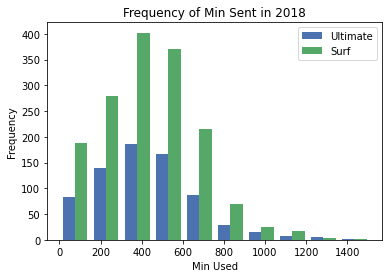

In [47]:
plt.style.use('seaborn-deep')

ultimate_min_used = df_monthly_ultimate['min_used']
surf_min_used = df_monthly_surf['min_used']
bins = np.linspace(-10, 10, 30)

plt.hist([ultimate_min_used, surf_min_used], bins=10, label=['Ultimate', 'Surf'])
plt.legend(loc='upper right')
plt.title('Frequency of Min Sent in 2018')
plt.xlabel('Min Used')
plt.ylabel('Frequency')
plt.show()

In [48]:
statistics(df_monthly_ultimate['min_used'])

Average: 430.45
Variance: 240.34
Standard deviation: 15.5


In [49]:
statistics(df_monthly_surf['min_used'])

Average: 428.75
Variance: 234.38
Standard deviation: 15.31


Total call minutes on a monthly basis for users of the Ultimate plan occur most frequently between 400-600 minutes. The data has a slight negative skew accentuated by the drop off that occurs after 800 minutes of monthly usage (variance here is high). Total call minutes on a monthly basis for users of the Surf plan occur most frequently between 350-600 minutes. The data for the surf plan also has a slight negative skew. Interestingly, the statistics on usage do not vary greatly between the two plans.

<a id='4.1.2'><a/> 
### 4.1.2 Text Usage
[Return to Table of Contents](#back)

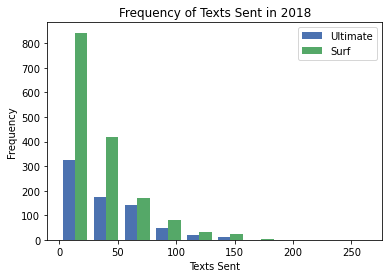

In [50]:
plt.style.use('seaborn-deep')

ultimate_text_used = df_monthly_ultimate['text_used']
surf_text_used = df_monthly_surf['text_used']
bins = np.linspace(-10, 10, 30)

plt.hist([ultimate_text_used, surf_text_used], bins=10, label=['Ultimate', 'Surf'])
plt.legend(loc='upper right')
plt.title('Frequency of Texts Sent in 2018')
plt.xlabel('Texts Sent')
plt.ylabel('Frequency')
plt.show()

In [51]:
statistics(df_monthly_ultimate['text_used'])

Average: 37.55
Variance: 34.74
Standard deviation: 5.89


In [52]:
statistics(df_monthly_surf['text_used'])

Average: 31.16
Variance: 33.56
Standard deviation: 5.79


Total texts sent on a monthly basis for users of both the Ultimate and Surf plans were most frequently under 25. For both plans there is a significant negative skew, meaning that there are more values below the mean than above it. It is of note that between 50 and 75 texts, in total, roughly the same number of texts are sent between the two plans, even though the sample size for surf is twice as large. Variance is high, meaning that the values are quite spread out from the mean.

<a id='4.1.3'><a/> 
### 4.1.3 Data Usage
[Return to Table of Contents](#back)

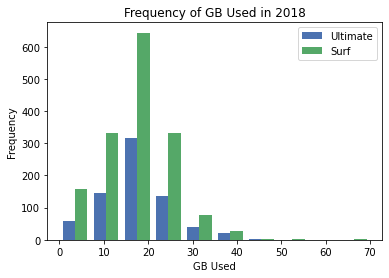

In [53]:
plt.style.use('seaborn-deep')

ultimate_gb_used = df_monthly_ultimate['gb_used']
surf_gb_used = df_monthly_surf['gb_used']
bins = np.linspace(-10, 10, 30)

plt.hist([ultimate_gb_used, surf_gb_used], bins=10, label=['Ultimate', 'Surf'])
plt.legend(loc='upper right')
plt.title('Frequency of GB Used in 2018')
plt.xlabel('GB Used')
plt.ylabel('Frequency')
plt.show()

In [54]:
statistics(df_monthly_ultimate['gb_used'])

Average: 17.31
Variance: 7.66
Standard deviation: 2.77


In [55]:
statistics(df_monthly_surf['gb_used'])

Average: 16.67
Variance: 7.85
Standard deviation: 2.8


Total gb used on a monthly basis for users of both the Ultimate and Surf plans were most frequently in the range of 10 to 30GB. For both plans, GB has a fairly normal distribution, not scattered, though there are some outliers. We can see this in the shape of the histogram and also given the variance.

<a id='4.1.4'><a/> 
### 4.1.4 Conclusion
[Return to Table of Contents](#back)

Strinkingly, the customer behavior of users of both plans is very similar. Users from both plans essentially make the same number of calls, send the same number of texts and use the same amount of data.

<a id='4.2'><a/> 
## 4.2 Revenue Analysis
[Return to Table of Contents](#back)

In [56]:
ultimate_clients_monthly = df_monthly_ultimate.groupby('month_year')['user_id'].count()
surf_clients_monthly = df_monthly_surf.groupby('month_year')['user_id'].count()
ultimate_revenue_monthly = df_monthly_ultimate.groupby('month_year')['total_payment'].sum()
surf_revenue_monthly = df_monthly_surf.groupby('month_year')['total_payment'].sum()

In [57]:
revenue_per_client_analysis=(pd.concat([ultimate_clients_monthly, ultimate_revenue_monthly, 
                            surf_clients_monthly, surf_revenue_monthly],1).reset_index())

In [58]:
revenue_per_client_analysis.columns = (['month_year', 'ultimate_clients', 'ultimate_revenues','surf_clients',
                                       'surf_revenues'])

In [59]:
revenue_per_client_analysis['ultimate_revenues_per_client'] = (revenue_per_client_analysis['ultimate_revenues']
                                                              / revenue_per_client_analysis['ultimate_clients'])
revenue_per_client_analysis['surf_revenues_per_client'] = (revenue_per_client_analysis['surf_revenues']
                                                              / revenue_per_client_analysis['surf_clients'])

In [60]:
revenue_per_client_analysis

,month_year,ultimate_clients,ultimate_revenues,surf_clients,surf_revenues,ultimate_revenues_per_client,surf_revenues_per_client
0,2018-01,4,280.00,2,40.00,70.000000,20.000000
1,2018-02,7,490.00,9,309.57,70.000000,34.396667
2,2018-03,12,840.08,23,1056.65,70.006667,45.941304
3,2018-04,21,1470.09,50,2035.53,70.004286,40.710600
4,2018-05,29,2030.03,77,3667.37,70.001034,47.628182
5,2018-06,47,3290.11,97,4779.80,70.002340,49.276289
6,2018-07,59,4130.16,121,7583.56,70.002712,62.674050
7,2018-08,71,4970.29,162,10356.85,70.004085,63.931173
8,2018-09,86,6020.25,194,11304.67,70.002907,58.271495
9,2018-10,106,7420.35,237,15504.83,70.003302,65.421224


In [61]:
print("2018 Ultimate Avg Revenue / Client:",round(revenue_per_client_analysis.ultimate_revenues_per_client.mean(),0))
print("2018 Surf Avg Revenue / Client:",round(revenue_per_client_analysis.surf_revenues_per_client.mean(),2))

2018 Ultimate Avg Revenue / Client: 70.0
2018 Surf Avg Revenue / Client: 51.4


In [62]:
print("2018 Ultimate Revenues:", round(revenue_per_client_analysis.ultimate_revenues.sum(),0))
print("2018 Surf Revenues:", round(revenue_per_client_analysis.surf_revenues.sum(),0))

2018 Ultimate Revenues: 50402.0
2018 Surf Revenues: 95491.0


Above we can see the revenues on a per client basis generated from the ultimate plan are consistently higher than those of the surf plan (except for the month of December which we'll attribute to increased communication during the holiday season). On average, the ultimate plan does not generate more than the plan cost as users generally do not go over. In the aggregate, the Surf Plan generates more gross revenues, nearly double what the Ultimate plan does.

<a id='5'><a/> 
# 5. Hypothesis Testing
[Return to Table of Contents](#back)

We have been asked to perform two tests:
<ul>
 <li>Test 1: Average profit from users of Ultimate and Surf calling plans differs</li>
 <li>Test 2: Average profit from users in NY / NJ area is different from that of the users from other regions</li>
 </ul>
 
To perform these tests, we will need to utilize samples taken from these two statistical populations.

<a id='5.1'><a/> 
## 5.1 Test 1: Average Profit from users of Ultimate and Surf Calling Plans
[Return to Table of Contents](#back)

<a id='5.1.1'><a/> 
### 5.1.1 Initial Statistical Review
[Return to Table of Contents](#back)

Before proceeding with the test, it will be helpful to perform a basic statistical review to get a sense for what the results of the test might tell us.

In [63]:
df_monthly.groupby('plan').total_payment.describe()

,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1573.0,60.706408,55.388042,20.0,20.0,40.36,80.36,590.37
ultimate,720.0,70.003306,0.016279,70.0,70.0,70.00,70.00,70.16


From the above we can conclude that the average monthly revenue for the Surf Plan is 60 dollars and the average monthly revenue for the Ultimate plan is 70 dollars. As mentioned previously, our sample size for the Surf plan is twice as large as that of the Ultimate plan. The standard deviation for Surf is high (this is because of the large spread in revenues) while that for Ultimate is considerably lower. Given that the standard deviation for Surf is high, we do not know if the difference between the surf and ultimate plans is statistically significant until we have run our t-test. 

<a id='5.1.2'><a/> 
### 5.1.2 Hypothesis Test
[Return to Table of Contents](#back)

Definitions:

<ul>
 <li>H0 (null hypothesis): average revenue per month for ultimate plan users = average revenue per month for surf users </li>
 <li>H1 (alternative hypothesis): average revenue per month for ultimate plan users <> average revenue per month for surf users </li>
 <li>Alpha: 0.05 (typical) </li>
 </ul>
 
If p_value < alpha, reject the null hypothesis. If p_value > alpha, fail to reject the null hypothesis.

In [64]:
# before testing the hypothesis using the T-test, we must check sample variance to understand which parameter equal_var to use

from scipy.stats import levene
stat, p = (levene(df_monthly[df_monthly.plan=='ultimate'].total_payment,
            df_monthly[df_monthly.plan=='surf'].total_payment))
p

1.570464076233721e-95

The small p-value (i.e. less than 0.05) suggests that the populations do NOT have equal variances.

In [65]:
(st.ttest_ind(df_monthly[df_monthly.plan=='ultimate'].total_payment,df_monthly[df_monthly.plan=='surf']
              .total_payment, equal_var=False))

Ttest_indResult(statistic=6.657119449292592, pvalue=3.8469655717157415e-11)

The p_value < 0.05 and thus we reject the null hypothesis of equal averages. There is a statistical difference in the revenues of the two plans. 

<a id='5.2'><a/> 
## 5.2 Test 2: Average profit from users in NY / NJ area is different from that of the users from other regions
[Return to Table of Contents](#back)

<a id='5.2.1'><a/> 
### 5.2.1 Initial Statistical Review
[Return to Table of Contents](#back)

Before proceeding with the test, it will be helpful to perform a basic statistical review to get a sense for what the results of the test might tell us.

In [ ]:
df_monthly.groupby('city')['total_payment'].describe().head(15)

In [ ]:
df_monthly.groupby('city')['total_payment'].describe().filter(items=['New York-Newark-Jersey City, NY-NJ-PA MSA','XOne'], axis=0)

There seems to be a lot of variation in the average revenues for the different locations and so we cannot make any conclusions at this point.

<a id='5.2.2'><a/> 
### 5.2.2 Hypothesis Test
[Return to Table of Contents](#back)

Definitions:

<ul>
 <li>H0 (null hypothesis): Average revenue from users in NY / NJ area = average revenue of users from other regions. I.e. average profits are the same </li>
 <li>H1 (alternative hypothesis): Average revenue from users in NY / NJ area <> average revenue of users from other regions. I.e. average profits differ. </li>
 <li>Alpha: 0.05 (typical) </li>
 </ul>
 
If p_value < alpha, we reject the null hypothesis. If p_value > alpha, fail to reject the null hypothesis.

In [ ]:
# before testing the hypothesis using the T-test, we must check sample variance to understand which parameter equal_var to use

from scipy.stats import levene
stat, p = (levene(df_monthly[df_monthly.city=='New York-Newark-Jersey City, NY-NJ-PA MSA'].
            total_payment,df_monthly[df_monthly.city!='New York-Newark-Jersey City, NY-NJ-PA MSA'].
                  total_payment))
p

The large p-value suggests that the populations do have equal variances.

In [ ]:
# T-test

(st.ttest_ind(df_monthly[df_monthly.city=='New York-Newark-Jersey City, NY-NJ-PA MSA'].total_payment, 
              df_monthly[df_monthly.city!='New York-Newark-Jersey City, NY-NJ-PA MSA'].total_payment))

The p_value > 0.05 and thus we fail to reject the null hypothesis of equal averages. There is no statistical difference in the revenues from NY / NJ versus other regions.

<a id='6'><a/> 
# 6. General Conclusion
[Return to Table of Contents](#back)

**Data Processing**

The files that we were provided were uniform and complete. The minor preprocessing that needed to be done involved properly categorizing data types. 

**Exploratory Data Analysis**

Before beginning EDA, the various data files were consolidated to put the following in one file: The number of calls made and minutes used per month, the number of text messages sent per month, the volume of data per month,and the monthly profit from each user. Once this had been completed, we were able to perform some high level analysis into uder behavior between the two plans. Interestingly, though the Ultimate plan is more expensive than the Surf Plan, users consumed nearly the same amount of calls, texts and GB per month:

<ul>
    <li>Ultimate average user: Calls (430), Texts (38), and GB (18)</li>
    <li>Surf average user: Calls (429), Texts (31), and GB (17)</li>
</ul>

**Hypothesis Testing**

For this exercise, we were asked to first compare the average revenue for the two plans and then to compare the average revenue for users within the NY/NJ  area and all those outside the area. For the first test, we concluded that there is a statistical difference between the revenues for the two plans. For the second test, we concluded as well that there is a statistical difference between the revenues for users wihtin NY / NJ and users in other regions. 

**Recommendations to Management for 2019 Advertising**

Based on the analysis performed users of both plans utilize virtually the same amount of calls, texts, and data, yet the Ultimate plan generates higher revenues per month on a per client basis: 70 versus 51. However, it is worth noting that the Surf plan generates gross revenues that are nearly twice that of the Ultimate Plan. As such, while targeting advertising efforts on potential Ultimate clients, regardless of region, would generate more revenue on a per client basis, we recommend that the team first analyze the client acquisiton rate. If increased advertising dollars do not yield a higher number of clients, then the money might have been better spent going for volume via Surf clients. 

In [ ]:
# please disregard. for my reference only

In [ ]:
for x in ['min_used']:
    #try:
        #print(x)
    statistics(df_monthly_ultimate[x])
    #except:
        #pass

In [ ]:
for x in df_monthly_ultimate.columns:
    #try:
        #print(x)
    statistics(df_monthly_ultimate[x])
    #except:
        #pass